In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from keras import backend as K 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
data = pd.read_csv('/gdrive/My Drive/github/интерсвязь - тестовое задание/tatarstan_message_2.csv', sep = ';')
print(data.columns)
data = data[['categories', 'description_stem']]
data.head(3)

Index(['Unnamed: 0', 'categories', 'description', 'description_prep',
       'description_stem'],
      dtype='object')


,categories,description_stem
0,Благоустройство территории,трасса нижнекамск чистополь лесополоса пгт кам...
1,Благоустройство территории,двор дом ленинградский отсутствовать парковочн...
2,Содержание и ремонт муниципальных дорог,добрый день осуществляться уборка снег центр г...


In [4]:
data = data.dropna()
text_train = data['description_stem'].to_list()

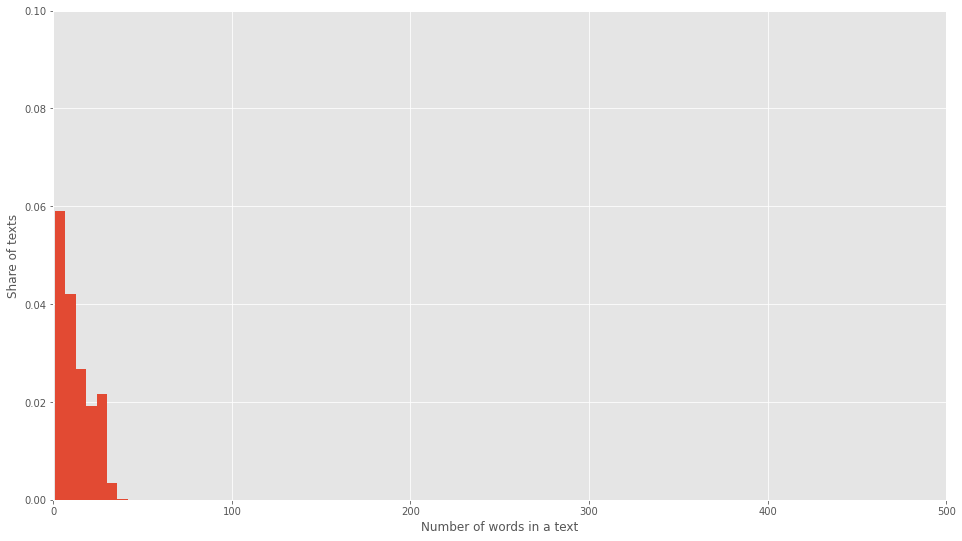

In [5]:
#гистограмма наиболее часто встречающегося количества слов
plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = data['description_stem'].apply(lambda x: len(x.split(' ')))
n, bins, patches = plt.hist(len_of_sent, 500, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 500, 0, 0.1])
plt.grid(True)
plt.show()

#выбираем количество анализируемых слов = 30

In [6]:
#загрузка модели Word2Vec
model = Word2Vec.load("/gdrive/My Drive/github/интерсвязь - тестовое задание/w2v_model/tweets_model.w2v")
model.delete_temporary_training_data()

In [7]:
#загрузка эмбеддингов из словаря модели
e_matrix = []
mydict = []
for word in model.wv.vocab.keys():
    try:
        e_matrix.append(model.wv[word])
        mydict.append(word)
        if len(e_matrix) >= 600000:
            break
    except:
        print("Пропущено слово при заполнении модели")
        continue

print(f"Размерность словаря для embedding {len(e_matrix)}")

NUM = len(e_matrix)
e_matrix = np.array(e_matrix, dtype=object)

Размерность словаря для embedding 600000


In [8]:
DIM = model.vector_size
print(DIM)
print(NUM)
tokenizer = Tokenizer(oov_token = True) #num_words = NUM
tokenizer.fit_on_texts(mydict)

SENTENCE_LENGTH = 30

print("подготовка обучающего набора")
raw_data = [row.split(' ') for row in data['description_stem']]
X = tokenizer.texts_to_sequences(raw_data) 
X = pad_sequences(X, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X[0])}")
print(X.shape)
print(X)

Y = pd.get_dummies(data['categories'])
label_columns=Y.columns #To get the classes
Y = Y.to_numpy() #Convert labels to numpy array
print(Y.shape)
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

200
600000
подготовка обучающего набора
Количество слов в предложении: 30
(28015, 30)
[[    0     0     0 ... 44432 30966 81127]
 [    0     0 16953 ...  5839  5959   594]
 [    0     0     0 ... 81127  2522 84833]
 ...
 [    0     0     0 ...     0 26641 26077]
 [    0     0  5638 ... 39383 35712  9499]
 [65932    67     1 ... 23944     1  9070]]
(28015, 36)
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [9]:
# Метрики 
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [10]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

SENTENCE_LENGTH = 30
NUM = 600000
DIM = 200

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32') 
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH, weights=[e_matrix], trainable=False)(tweet_input) #Слой Emdedding

branches = []

x = Dropout(0.2)(tweet_encoder)
for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(300, activation='relu')(x)
output = Dense(36, activation='softmax')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      120000000   input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 200)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 29, 1)        401         dropout[0][0]                    
______________________________________________________________________________________________

In [11]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("CNN_Word2Vec_600000-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.2, callbacks = [checkpoint])

Epoch 1/200
561/561 [==============================] - 20s 16ms/step - loss: 0.0971 - accuracy: 0.4720 - precision: 0.4873 - recall: 0.3816 - f1: 0.4231 - val_loss: 0.0633 - val_accuracy: 0.6253 - val_precision: 0.7344 - val_recall: 0.3662 - val_f1: 0.4842
Epoch 2/200
204/561 [=========>....................] - ETA: 4s - loss: 0.0556 - accuracy: 0.6161 - precision: 0.6475 - recall: 0.5606 - f1: 0.5998

KeyboardInterrupt: ignored

In [12]:
plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

NameError: ignored

In [13]:
model.load_weights('/gdrive/My Drive/github/интерсвязь - тестовое задание/CNN_Word2Vec_2-20-0.79.hdf5')

In [14]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))

Оценки тестового набора:
              precision    recall  f1-score   support

           0      0.750     0.280     0.408        75
           1      0.939     0.891     0.914       156
           2      0.769     0.820     0.794      2604
           3      0.000     0.000     0.000         6
           4      0.944     0.500     0.654        34
           5      0.250     0.118     0.160        17
           6      0.000     0.000     0.000         1
           7      0.833     0.333     0.476        15
           8      0.000     0.000     0.000         4
           9      0.750     0.391     0.514        23
          10      0.000     0.000     0.000         3
          11      0.897     0.788     0.839        33
          12      0.900     0.877     0.888       439
          13      0.000     0.000     0.000         0
          14      0.000     0.000     0.000         1
          15      0.000     0.000     0.000         2
          16      0.810     0.657     0.726       175
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("CNN_Word2Vec_2-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_split=0.25, callbacks = [checkpoint])

In [ ]:
plot_history(history_trainable)

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))